In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import os
import pickle
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-08-03 01:00:26.252927: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-03 01:00:26.282593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-03 01:00:26.282831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-03 01:00:26.284343: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-03 01:00:26.286273: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-03 01:00:26.286504: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [4]:
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)
mae = make_mae(bkgd, sgnl)
lr = make_lr(bkgd, sgnl)

# LR Plots with Naive Implementation

In [31]:
num = 2
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl)
lr = make_lr(bkgd, sgnl)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

## Mean Absolute Errors

In [30]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mae_err = []
mse_mae_err = []
mlc_mae_err = []
sqr_mae_err = []

for N in Ns:
    print(N)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, i))
        mse_lrs[i] = odds_lr(mse_model)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, i))
        mlc_lrs[i] = pure_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, i))
        sqr_lrs[i] = pure_lr(sqr_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    mse_mae_avg += [np.mean(mse_maes)]
    mlc_mae_avg += [np.mean(mlc_maes)]
    sqr_mae_avg += [np.mean(sqr_maes)]
    
    '''
    bce_mae_err += [np.std(bce_maes)]
    mse_mae_err += [np.std(mse_maes)]
    mlc_mae_err += [np.std(mlc_maes)]
    sqr_mae_err += [np.std(sqr_maes)]
    '''

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

'''
bce_mae_err = np.array(bce_mae_err)
mse_mae_err = np.array(mse_mae_err)
mlc_mae_err = np.array(mlc_mae_err)
sqr_mae_err = np.array(sqr_mae_err)
'''

100


2022-08-02 06:56:49.890416: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-08-02 06:56:49.898484: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994530000 Hz
2022-08-02 06:56:49.899610: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561985d8a000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-02 06:56:49.899636: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-02 06:56:50.010792: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561983a1d4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-02 06:56:50.010840: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2022-08-02 06:56:50.012466: I 

OSError: Unable to open file (unable to open file: name = 'models/univariate/loss_comp/set_3//bce/model_100_0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

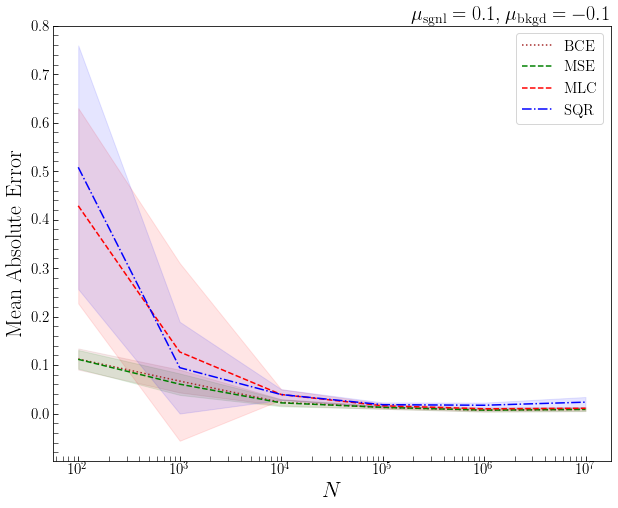

In [29]:
# Plot MAEs
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(Ns, sqr_mae_avg, c='blue', ls='-.', label='SQR')
plt.fill_between(Ns, bce_mae_avg - bce_mae_err, bce_mae_avg + bce_mae_err, color='brown', alpha=0.1)
plt.fill_between(Ns, mse_mae_avg - mse_mae_err, mse_mae_avg + mse_mae_err, color='green', alpha=0.1)
plt.fill_between(Ns, mlc_mae_avg - mlc_mae_err, mlc_mae_avg + mlc_mae_err, color='red', alpha=0.1)
plt.fill_between(Ns, sqr_mae_avg - sqr_mae_err, sqr_mae_avg + sqr_mae_err, color='blue', alpha=0.1)
plt.legend()

plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(0.1)+r", \mu_{\rm{bkgd}}="+str(-0.1)+r"$",
          loc="right",
          fontsize=20);
plt.savefig('plots/may_9/naive_maes_error.png',
            dpi=1200, 
            bbox_inches='tight')

## Likelihood Ratios

In [61]:
N = 10**6
reps = 100

In [62]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model, 0, 1)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = odds_lr(mse_model, 0, 1)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = pure_lr(mlc_model, 0, 1)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = pure_lr(sqr_model, 0, 1)

In [64]:
bce_lr = avg_lr(get_preds(bce_lrs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs)) + ('SQR',)

bce_lrr = avg_lrr(lr, get_preds(bce_lrs)) + ('BCE',)
mse_lrr = avg_lrr(lr, get_preds(mse_lrs)) + ('MSE',)
mlc_lrr = avg_lrr(lr, get_preds(mlc_lrs)) + ('MLC',)
sqr_lrr = avg_lrr(lr, get_preds(sqr_lrs)) + ('SQR',)

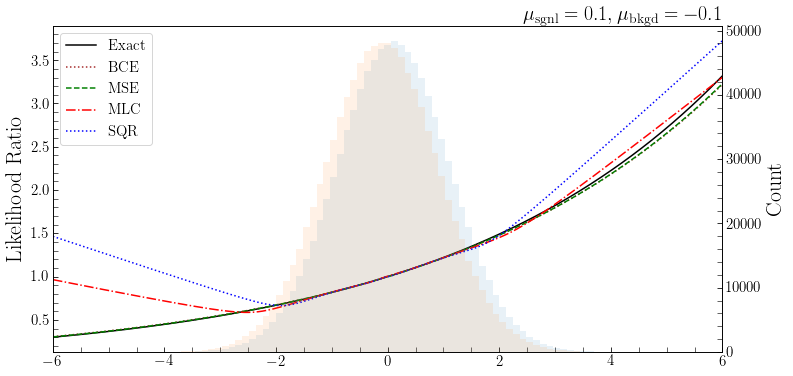

In [66]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        lr,
        bkgd, sgnl,
        filename='plots/paper/naive_lrs.png',
        figsize = (12, 6))

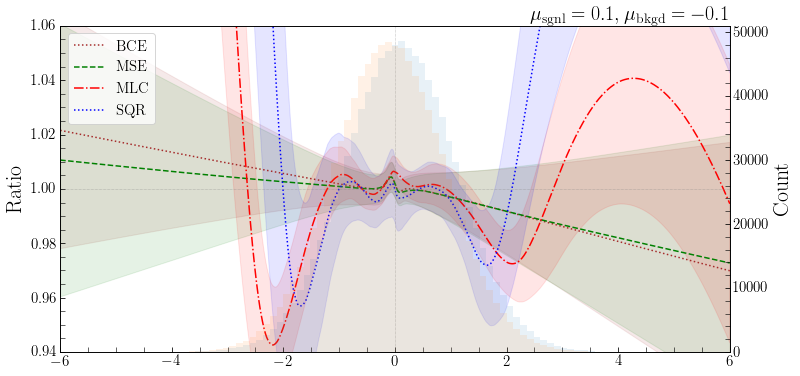

In [35]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         lr,
         bkgd, sgnl,
         filename='plots/may_9/naive_lrrs_error.png',
         figsize = (12, 6))

# $C$ Parametrizations

## MLC

In [67]:
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output':'relu'}
params_2 = {'loss':square_mlc, 'output':'linear'}
params_3 = {'loss':exp_mlc, 'output':'linear'}

filestr_1 = 'models/mlc_c_param/set_' + str(num) + '/linear/mlc_model_{}.h5'
filestr_2 = 'models/mlc_c_param/set_' + str(num) + '/square/square_mlc_model_{}.h5'
filestr_3 = 'models/mlc_c_param/set_' + str(num) + '/exp/exp_mlc_model_{}.h5'

In [68]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1)
    lrs_2[i] = square_lr(model_2)
    lrs_3[i] = exp_lr(model_3)

In [69]:
lr_1 = avg_lr(get_preds(lrs_1)) + ('Linear',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('Square',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('Exponential',)

lrr_1 = avg_lrr(lr, get_preds(lrs_1)) + ('Linear',)
lrr_2 = avg_lrr(lr, get_preds(lrs_2)) + ('Square',)
lrr_3 = avg_lrr(lr, get_preds(lrs_3)) + ('Exponential',)

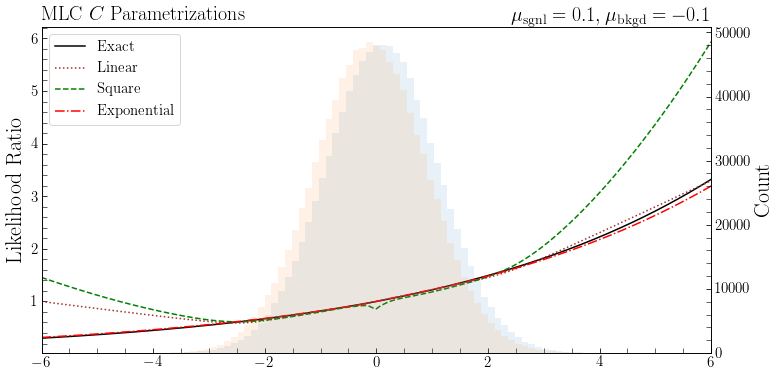

In [70]:
lr_plot([lr_1, lr_2, lr_3], 
        lr,
        bkgd, sgnl,
        title=r'MLC $C$ Parametrizations',
        filename='plots/may_9/mlc_c_param_lrs.png', 
        figsize = (12, 6))

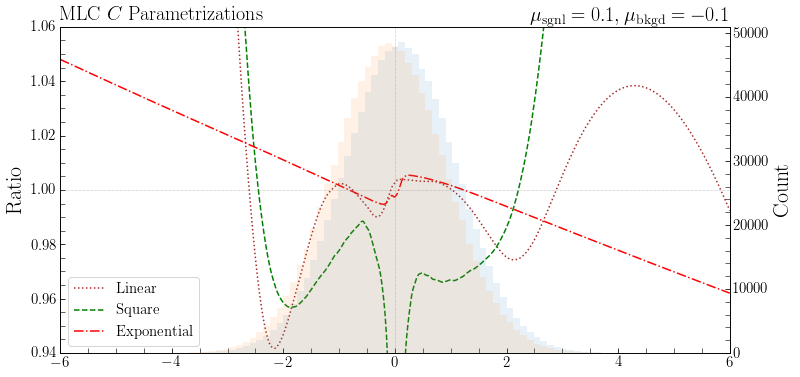

In [71]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         lr,
         bkgd, sgnl,
         title=r'MLC $C$ Parametrizations',
         filename='plots/may_9/mlc_c_param_lrrs.png', 
         figsize = (12, 6))

## SQR

In [72]:
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output':'relu'}
params_2 = {'loss':square_sqr, 'output':'linear'}
params_3 = {'loss':exp_sqr, 'output':'linear'}

filestr_1 = 'models/sqr_c_param/set_' + str(num) + '/linear/sqr_model_{}.h5'
filestr_2 = 'models/sqr_c_param/set_' + str(num) + '/square/square_sqr_model_{}.h5'
filestr_3 = 'models/sqr_c_param/set_' + str(num) + '/exp/exp_sqr_model_{}.h5'

In [73]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1)
    lrs_2[i] = square_lr(model_2)
    lrs_3[i] = exp_lr(model_3)

In [74]:
lr_1 = avg_lr(get_preds(lrs_1)) + ('Linear',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('Square',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('Exponential',)

lrr_1 = avg_lrr(lr, get_preds(lrs_1)) + ('Linear',)
lrr_2 = avg_lrr(lr, get_preds(lrs_2)) + ('Square',)
lrr_3 = avg_lrr(lr, get_preds(lrs_3)) + ('Exponential',)

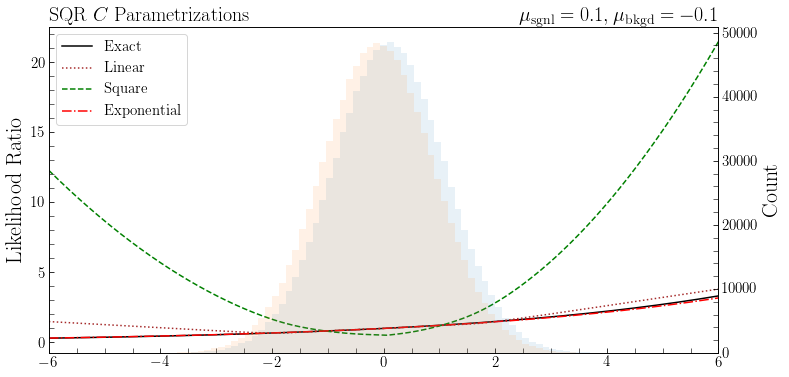

In [75]:
lr_plot([lr_1, lr_2, lr_3], 
        lr,
        bkgd, sgnl,
        title=r'SQR $C$ Parametrizations',
        filename='plots/may_9/sqr_c_param_lrs.png',
        figsize = (12, 6))

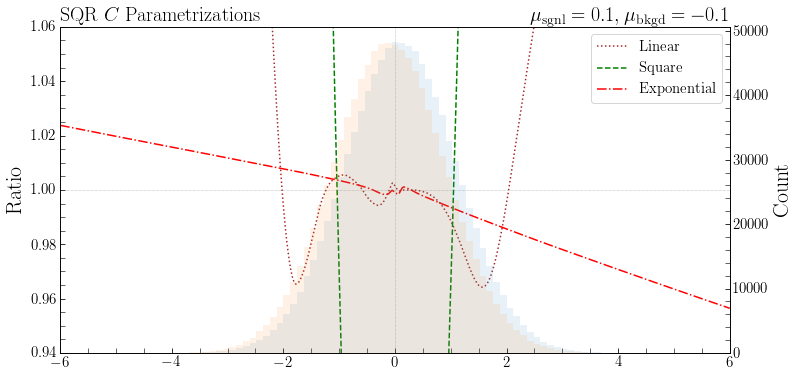

In [76]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         lr, 
         bkgd, sgnl,
         title=r'SQR $C$ Parametrizations',
         filename='plots/may_9/sqr_c_param_lrrs.png',
         figsize = (12, 6))

# $A/B$ Parametrizations

## SQR

In [2]:
import numpy as np

In [ ]:
num = 2
reps = 20

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))
sqr_filestr = 'models/sqr_ab_param/set_' + str(num) + '/linear/model_{}_{}.h5'
exp_filestr = 'models/sqr_ab_param/set_' + str(num) + '/exp/model_{}_{}.h5'

In [ ]:
# Get model likelihood ratios.
sqr_lrs = {}
exp_lrs = {}
for r in rs:
    print(r)
    sqr_lrs[r] = [None] * reps
    exp_lrs[r] = [None] * reps
    sqr_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    for i in range(reps):
        sqr_model = create_model(**sqr_params)
        exp_model = create_model(**exp_params)
        sqr_model.load_weights(sqr_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        sqr_lrs[r][i] = pow_lr(sqr_model, r)
        exp_lrs[r][i] = exp_pow_lr(exp_model, r)
        print(i, end = ' ')
    print()

In [ ]:
for r in rs:
    sqr_maes = [mae(lr) for lr in sqr_lrs[r]]
    exp_maes = [mae(lr) for lr in exp_lrs[r]]
    
    sqr_mae_avg += [np.mean(sqr_maes)]
    exp_mae_avg += [np.mean(exp_maes)]
    '''
    if r == 1:
        sqr_mae = open('pickles/sqr_mae.pkl', 'wb')
        pickle.dump(sqr_mae_avg, sqr_mae)
        sqr_mae.close()
        
        exp_mae = open('pickles/exp_mae.pkl', 'wb')
        pickle.dump(exp_mae_avg, exp_mae)
        exp_mae.close()
    '''
    print(r, '\t', sqr_mae_avg[-1], '\t', exp_mae_avg[-1])

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(rs, sqr_mae_avg, c='blue', label='linear')
plt.plot(rs, exp_mae_avg, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
plt.ylim(0, 0.2)

plt.title(r"$\mu_{\rm{sgnl}}="+str(0.1)+r", \mu_{\rm{bkgd}}="+str(-0.1)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/may_9/sqr_ab_param_maes_fine.png'.format(num), 
            dpi=1200, 
            bbox_inches='tight')

## MSE

In [ ]:
num = 0
reps = 20

ps = np.round(np.linspace(-4, 4, 161), 2)
filestr = 'models/mse_ab_param/set_' + str(num) + '/model_{}_{}.h5'

In [ ]:
# Get model likelihood ratios.
lrs = {}
for p in ps:
    print(p)
    lrs[p] = [None] * reps
    params = {'loss': get_mse(p)}
    for i in range(reps):
        model = create_model(**mse_params)
        model.load_weights(filestr.format(p, i))
        lrs[p][i] = pow_odds_lr(model, p) #### FIX THIS
        print(i, end = ' ')
    print()

In [ ]:
mae_avg = []
for p in ps:
    maes = [mae(lr) for lr in lrs[p]]
    mae_avg += [np.mean(maes)]
    print(p, '\t', mae_avg[-1])

In [ ]:
mae_avg = np.array(mae_avg)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(ps, mae_avg, c='blue')

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylim(0, 0.5)

plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(0.1)+r", \mu_{\rm{bkgd}}="+str(-0.1)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"MSE $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/may_9/mse_ab_param_maes.png'.format(num), 
            dpi=1200, 
            bbox_inches='tight')

# Optimized Performances

In [43]:
num = 0
reps = 100
Ns = 10**np.arange(2, 8)

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)
mae = make_mae(bkgd, sgnl)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':get_mse(1.25)}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':get_exp_sqr(0.05), 'output':'linear'}

bce_filestr = 'models/loss_comp/set_' + str(num) + '/bce/bce_model_{}_{}.h5'
mse_filestr = 'models/loss_comp/set_' + str(2) + '/mse/model_{}_{}.h5'
mlc_filestr = 'models/loss_comp/set_' + str(num) + '/mlc/mlc_model_{}_{}.h5'
sqr_filestr = 'models/loss_comp/set_' + str(2) + '/sqr/model_{}_{}.h5'

## Mean Absolute Errors

In [12]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mae_err = []
mse_mae_err = []
mlc_mae_err = []
sqr_mae_err = []

for N in Ns:
    print(N)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, i))
        mse_lrs[i] = pow_odds_lr(mse_model, 1.25)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, i))
        mlc_lrs[i] = exp_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, i))
        sqr_lrs[i] = exp_pow_lr(sqr_model, 0.05)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    mse_mae_avg += [np.mean(mse_maes)]
    mlc_mae_avg += [np.mean(mlc_maes)]
    sqr_mae_avg += [np.mean(sqr_maes)]
    
    bce_mae_err += [np.std(bce_maes)]
    mse_mae_err += [np.std(mse_maes)]
    mlc_mae_err += [np.std(mlc_maes)]
    sqr_mae_err += [np.std(sqr_maes)]

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

bce_mae_err = np.array(bce_mae_err)
mse_mae_err = np.array(mse_mae_err)
mlc_mae_err = np.array(mlc_mae_err)
sqr_mae_err = np.array(sqr_mae_err)

100
1000
10000
100000
1000000
10000000


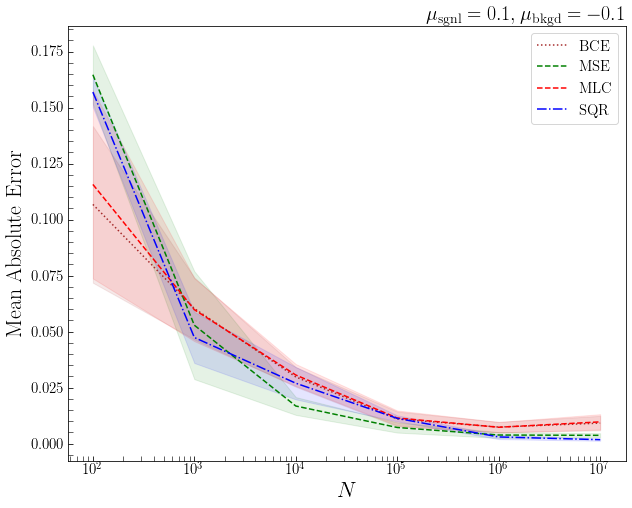

In [13]:
# Plot MAEs
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(Ns, sqr_mae_avg, c='blue', ls='-.', label='SQR')
plt.fill_between(Ns, bce_mae_avg - bce_mae_err, bce_mae_avg + bce_mae_err, color='brown', alpha=0.1)
plt.fill_between(Ns, mse_mae_avg - mse_mae_err, mse_mae_avg + mse_mae_err, color='green', alpha=0.1)
plt.fill_between(Ns, mlc_mae_avg - mlc_mae_err, mlc_mae_avg + mlc_mae_err, color='red', alpha=0.1)
plt.fill_between(Ns, sqr_mae_avg - sqr_mae_err, sqr_mae_avg + sqr_mae_err, color='blue', alpha=0.1)
plt.legend()

plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(0.1)+r", \mu_{\rm{bkgd}}="+str(-0.1)+r"$",
          loc="right",
          fontsize=20);
plt.savefig('plots/may_9/best_maes_error.png',
            dpi=1200, 
            bbox_inches='tight')

## Likelihood Ratios

In [44]:
N = 10**6
reps = 100

In [45]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = pow_odds_lr(mse_model, 1.25)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = exp_pow_lr(sqr_model, 0.05)

In [46]:
bce_lr = avg_lr(get_preds(bce_lrs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs)) + ('SQR',)

bce_lrr = avg_lrr(lr, get_preds(bce_lrs)) + ('BCE',)
mse_lrr = avg_lrr(lr, get_preds(mse_lrs)) + ('MSE',)
mlc_lrr = avg_lrr(lr, get_preds(mlc_lrs)) + ('MLC',)
sqr_lrr = avg_lrr(lr, get_preds(sqr_lrs)) + ('SQR',)

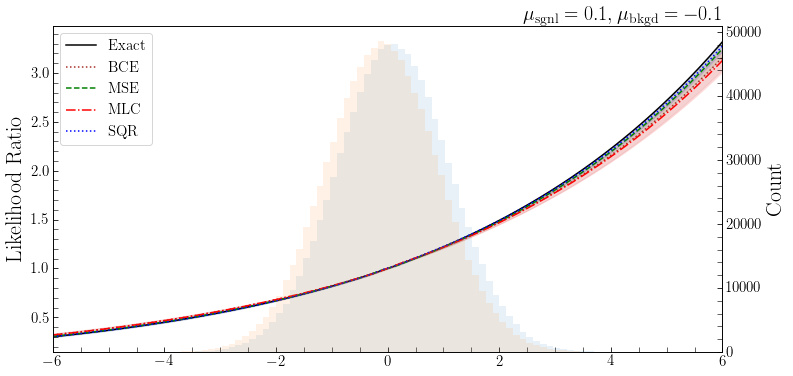

In [49]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr],
        lr,
        bkgd, sgnl,
        filename='plots/may_9/best_lrs_error.png',
        figsize = (12, 6))

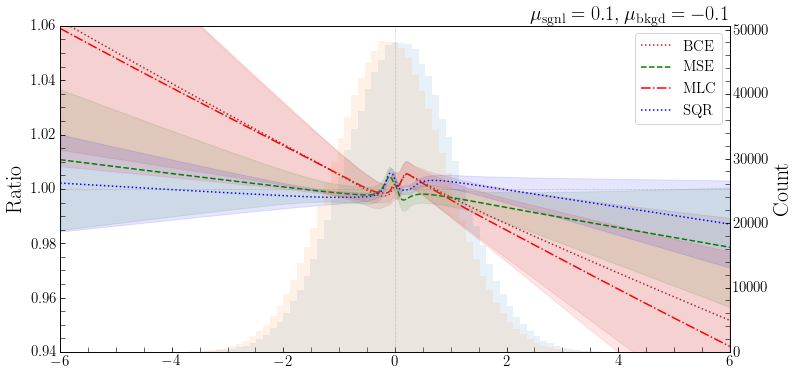

In [48]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
         lr,
         bkgd, sgnl,
         filename='plots/may_9/best_lrrs_error.png',
         figsize = (12, 6))

# Backup 2: Moving Gaussians

In [82]:
num = 5
N = 10**6
mus = np.round(np.linspace(0.1, 1.4, 14), 2)
ds = 2 * mus # distances between gaussians

reps = 50

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/interp/set_' + str(num) + '/bce/model_{}_{}.h5'
mse_filestr = 'models/interp/set_' + str(num) + '/mse/model_{}_{}.h5'
mlc_filestr = 'models/interp/set_' + str(num) + '/mlc/model_{}_{}.h5'
sqr_filestr = 'models/interp/set_' + str(num) + '/sqr/model_{}_{}.h5'

In [84]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mpe_avg = []
mse_mpe_avg = []
mlc_mpe_avg = []
sqr_mpe_avg = []

for mu in mus:
    print(mu)
    bkgd = stats.norm(-mu, 1)
    sgnl = stats.norm(mu, 1)
    
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(mu, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(mu, i))
        mse_lrs[i] = odds_lr(mse_model)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(mu, i))
        mlc_lrs[i] = exp_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(mu, i))
        sqr_lrs[i] = exp_lr(sqr_model)
    
    mae = make_mae(bkgd, sgnl)
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    mse_mae_avg += [np.mean(mse_maes)]
    mlc_mae_avg += [np.mean(mlc_maes)]
    sqr_mae_avg += [np.mean(sqr_maes)]
    print(bce_mae_avg[-1], mse_mae_avg[-1], mlc_mae_avg[-1], sqr_mae_avg[-1])
    
    
    mpe = make_mpe(bkgd, sgnl)
    bce_mpes = [mpe(lr) for lr in bce_lrs]
    mse_mpes = [mpe(lr) for lr in mse_lrs]
    mlc_mpes = [mpe(lr) for lr in mlc_lrs]
    sqr_mpes = [mpe(lr) for lr in sqr_lrs]
    
    bce_mpe_avg += [np.mean(bce_mpes)]
    mse_mpe_avg += [np.mean(mse_mpes)]
    mlc_mpe_avg += [np.mean(mlc_mpes)]
    sqr_mpe_avg += [np.mean(sqr_mpes)]
    print(bce_mpe_avg[-1], mse_mpe_avg[-1], mlc_mpe_avg[-1], sqr_mpe_avg[-1])

0.1
0.005728743607632095 0.006294645558765044 0.006190721440024642 0.005950107764054239
0.5504400130112905 0.6139002314424601 0.6013931438733198 0.5808276122767382
0.2
0.013840394871990444 0.012456899426029764 0.015274850448565398 0.013288723308105073
1.2526174573909432 1.1521790415949236 1.3254731231732537 1.240692204951079
0.3
0.019962787368433987 0.01777841779791091 0.028308035802147902 0.02486058669862288
1.407122443640903 1.1643959586295793 1.7544471695201447 1.6547840789132366
0.4
0.03394983048884154 0.025692781576414435 0.04877608357919479 0.03993047095488523
1.7504275515050005 1.3162872177971081 2.197341013653736 2.0831519895765163
0.5
0.06630381260983965 0.0307569892444069 0.10365930915273891 0.07677456075398728
2.080896438575543 1.0467815841431456 2.795684992056733 2.4508922957337504
0.6
0.12459009542710746 0.04723338382920475 0.22603819389628485 0.17938118085548468
2.1431660080203945 0.9960601853536175 3.6041041913469143 3.3123924563901506
0.7
0.21466596028828416 0.073045915

In [85]:
bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

bce_mpe_avg = np.array(bce_mpe_avg)
mse_mpe_avg = np.array(mse_mpe_avg)
mlc_mpe_avg = np.array(mlc_mpe_avg)
sqr_mpe_avg = np.array(sqr_mpe_avg)

/tmp/ipykernel_23906/3405810487.py:9: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale("log", basey=10)


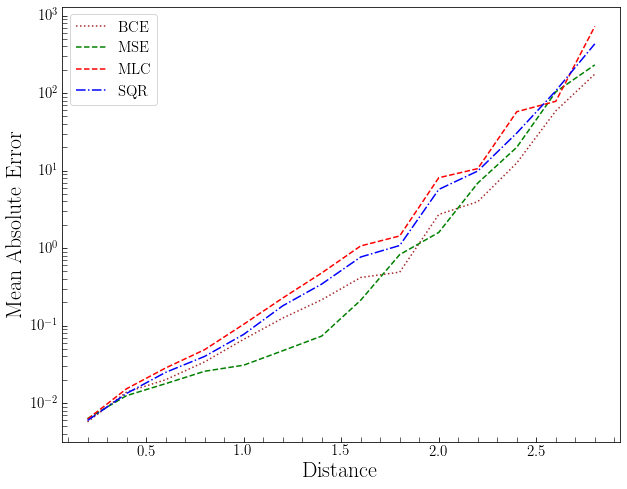

In [91]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(ds, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(ds, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(ds, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(ds, sqr_mae_avg, c='blue', ls='-.', label='SQR')
plt.legend()

plt.yscale("log", basey=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Distance')

plt.savefig('plots/may_9/moving_means_maes.png'.format(num),
            dpi=1200, 
            bbox_inches='tight')

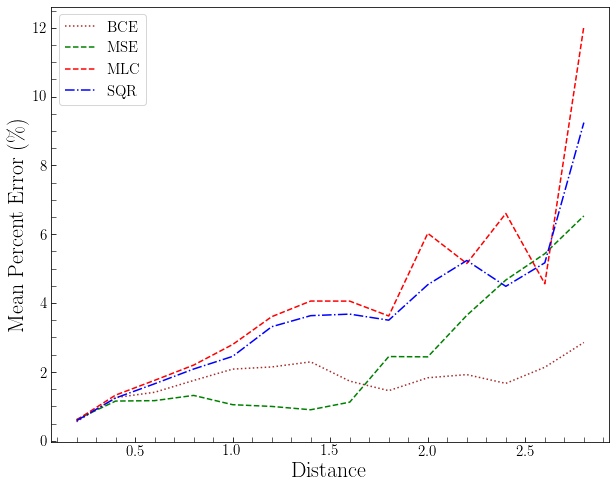

In [92]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(ds, bce_mpe_avg, c='brown', ls=':', label='BCE')
plt.plot(ds, mse_mpe_avg, c='green', ls='--', label='MSE')
plt.plot(ds, mlc_mpe_avg, c='red', ls='--', label='MLC')
plt.plot(ds, sqr_mpe_avg, c='blue', ls='-.', label='SQR')
plt.legend()
#plt.ylim(0, 5)

#plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Percent Error (\%)')
plt.xlabel('Distance')

plt.savefig('plots/may_9/moving_means_mpes.png'.format(num),
            dpi=1200, 
            bbox_inches='tight')

# Backup 3: Other Distributions

## Betas

In [90]:
num = 0
N = 10**6
reps = 100

bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)
lr = make_lr(bkgd, sgnl)

bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/betas/set_' + str(num) + '/bce/model_{}.h5'
mse_filestr = 'models/betas/set_' + str(num) + '/mse/model_{}.h5'
mlc_filestr = 'models/betas/set_' + str(num) + '/mlc/model_{}.h5'
sqr_filestr = 'models/betas/set_' + str(num) + '/sqr/model_{}.h5'

In [91]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [92]:
m = (bkgd.mean() + sgnl.mean()) / 2
s = ((bkgd.var() + sgnl.var()) / 2 + np.var([bkgd.mean(), sgnl.mean()]))**0.5

In [93]:
ds = np.linspace(0, 1, 1000)
xs = (ds - m) / s

bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(lr, get_preds(bce_lrs, xs), ds) + ('BCE',)
mse_lrr = avg_lrr(lr, get_preds(mse_lrs, xs), ds) + ('MSE',)
mlc_lrr = avg_lrr(lr, get_preds(mlc_lrs, xs), ds) + ('MLC',)
sqr_lrr = avg_lrr(lr, get_preds(sqr_lrs, xs), ds) + ('SQR',)

/clusterfs/ml4hep/shahzar/ATLASOmniFold/utils/training.py:80: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: sgnl.pdf(x) / bkgd.pdf(x)


/clusterfs/ml4hep/shahzar/ATLASOmniFold/utils/training.py:80: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: sgnl.pdf(x) / bkgd.pdf(x)


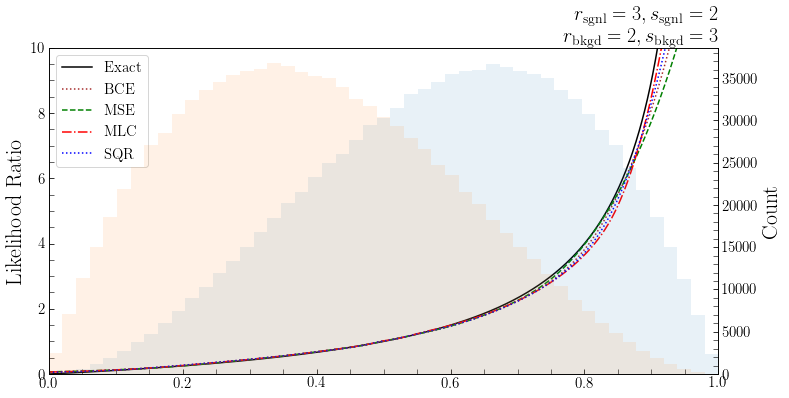

In [97]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        lr,
        bkgd, sgnl,
        xs = ds,
        bins = np.linspace(0, 1, 50),
        filename='plots/may_9/beta_lrs.png',
        params=r"$r_{\rm{sgnl}}="+str(3)+r", s_{\rm{sgnl}}="+str(2)+ r"$" + "\n" + r"$r_{\rm{bkgd}}="+str(2)+r", s_{\rm{bkgd}}=" + str(3) + r"$",
        figsize = (12, 6))

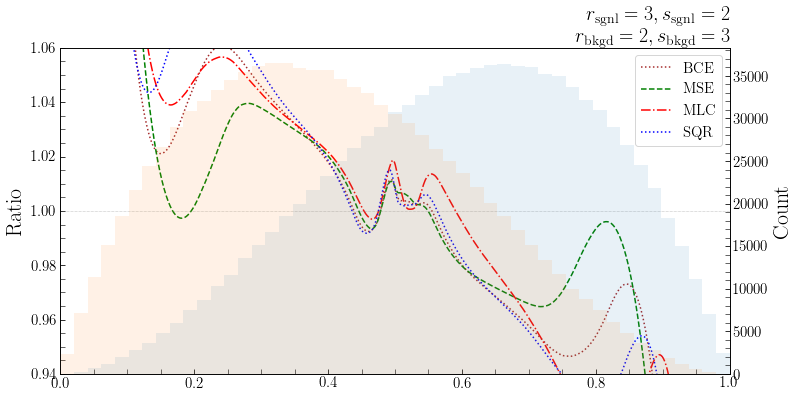

In [99]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
        lr,
        bkgd, sgnl,
        xs = ds,
        bins = np.linspace(0, 1, 50),
        filename='plots/may_9/beta_lrrs.png',
        params=r"$r_{\rm{sgnl}}="+str(3)+r", s_{\rm{sgnl}}="+str(2)+ r"$" + "\n" + r"$r_{\rm{bkgd}}="+str(2)+r", s_{\rm{bkgd}}=" + str(3) + r"$",
        figsize = (12, 6))

## Gammas

In [100]:
num = 0
N = 10**6
reps = 100

bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)
lr = make_lr(bkgd, sgnl)

bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/gammas/set_' + str(num) + '/bce/model_{}.h5'
mse_filestr = 'models/gammas/set_' + str(num) + '/mse/model_{}.h5'
mlc_filestr = 'models/gammas/set_' + str(num) + '/mlc/model_{}.h5'
sqr_filestr = 'models/gammas/set_' + str(num) + '/sqr/model_{}.h5'

In [101]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [102]:
m = (bkgd.mean() + sgnl.mean()) / 2
s = ((bkgd.var() + sgnl.var()) / 2 + np.var([bkgd.mean(), sgnl.mean()]))**0.5

In [103]:
ds = np.linspace(0, 20, 1000)
xs = (ds - m) / s

bce_lr = avg_lr(get_preds(bce_lrs, xs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs, xs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs, xs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs, xs)) + ('SQR',)

bce_lrr = avg_lrr(lr, get_preds(bce_lrs, xs), ds) + ('BCE',)
mse_lrr = avg_lrr(lr, get_preds(mse_lrs, xs), ds) + ('MSE',)
mlc_lrr = avg_lrr(lr, get_preds(mlc_lrs, xs), ds) + ('MLC',)
sqr_lrr = avg_lrr(lr, get_preds(sqr_lrs, xs), ds) + ('SQR',)

/clusterfs/ml4hep/shahzar/ATLASOmniFold/utils/training.py:80: RuntimeWarning: invalid value encountered in true_divide
  return lambda x: sgnl.pdf(x) / bkgd.pdf(x)


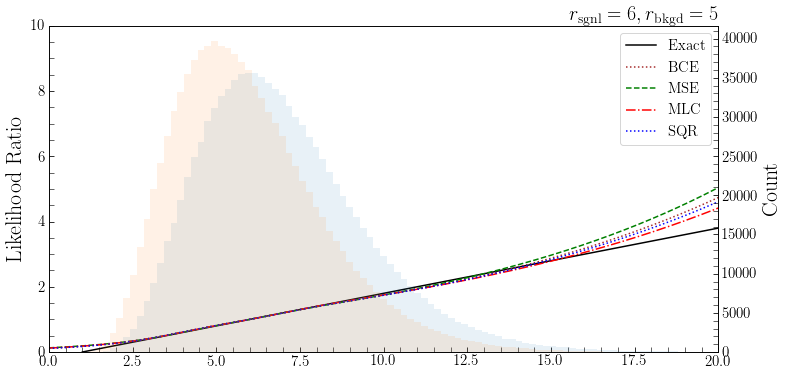

In [104]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], 
        lr,
        bkgd, sgnl,
        xs = ds,
        bins = np.linspace(0, 20, 100),
        filename='plots/may_9/gamma_lrs.png',
        params =r"$r_{\rm{sgnl}}="+str(6)+r", r_{\rm{bkgd}}="+str(5)+r"$",
        figsize = (12, 6))

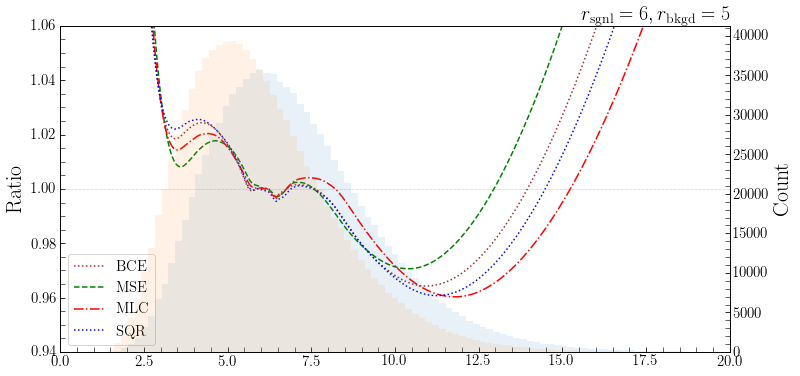

In [105]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], 
        lr,
        bkgd, sgnl,
        xs = ds,
        bins = np.linspace(0, 20, 100),
        filename='plots/may_9/gamma_lrrs.png',
        params =r"$r_{\rm{sgnl}}="+str(6)+r", r_{\rm{bkgd}}="+str(5)+r"$",
        figsize = (12, 6))

# Backup 4: $C$ Parametrizations for BCE & MSE

## BCE

In [162]:
num = 0
reps = 10

bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(0.1, 1)
lr = make_lr(bkgd, sgnl)

# Model parameters
params_1 = {'loss':bce, 'output':'sigmoid'}
params_2 = {'loss':square_mlc, 'output':'linear'}
params_3 = {'loss':exp_mlc, 'output':'linear'}

filestr_1 = 'models/bce_c_param/set_' + str(num) + '/linear/model_{}.h5'
filestr_2 = 'models/bce_c_param/set_' + str(num) + '/square/model_{}.h5'
filestr_3 = 'models/bce_c_param/set_' + str(num) + '/exp/model_{}.h5'

In [163]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1)
    lrs_2[i] = square_odds_lr(model_2)
    lrs_3[i] = exp_odds_lr(model_3)

In [169]:
# Get average predictions and errors. Add on the labels for plotting.
lr_1 = avg_lr(get_preds(lrs_1)) + ('Linear',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('Square',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('Exponential',)

lrr_1 = avg_lrr(lr, get_preds(lrs_1)) + ('Linear',)
lrr_2 = avg_lrr(lr, get_preds(lrs_2)) + ('Square',)
lrr_3 = avg_lrr(lr, get_preds(lrs_3)) + ('Exponential',)

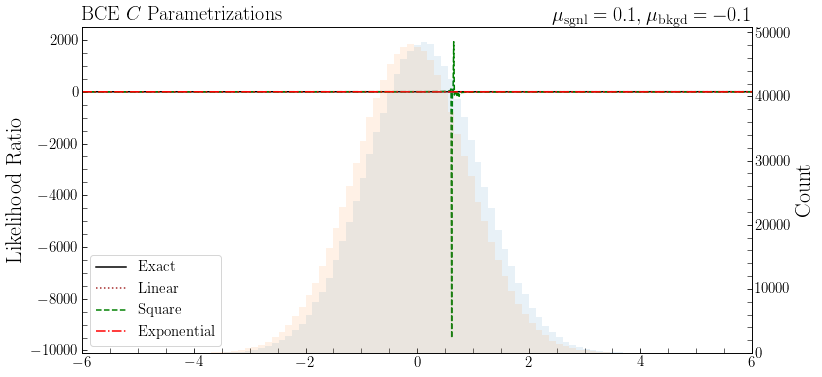

In [170]:
lr_plot([lr_1, lr_2, lr_3], 
        lr, bkgd, sgnl,
        title = r'BCE $C$ Parametrizations',
        filename='plots/may_9/bce_c_param_lrs.png', figsize = (12, 6))

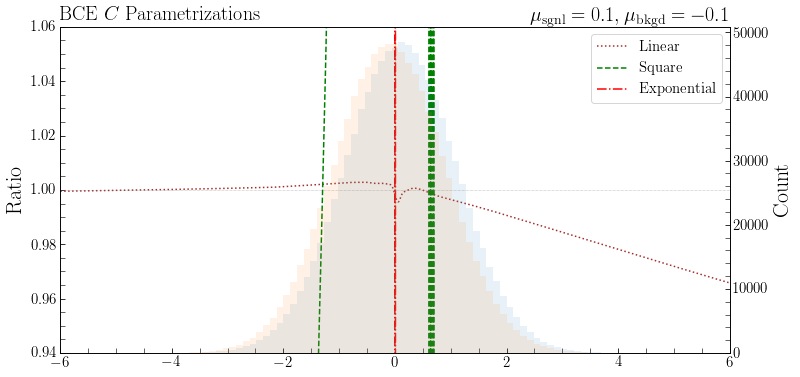

In [171]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         lr, bkgd, sgnl,
         title = r'BCE $C$ Parametrizations',
         filename='plots/may_9/bce_c_param_lrrs.png', figsize = (12, 6))

## MSE

In [ ]:
num = 0
reps = 10
mu = 0.1

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':square_mse, 'output':'linear'}
params_3 = {'loss':exp_mse, 'output':'linear'}

filestr_1 = 'models/mse_c_param/set_' + str(num) + '/linear/model_{}.h5'
filestr_2 = 'models/mse_c_param/set_' + str(num) + '/square/model_{}.h5'
filestr_3 = 'models/mse_c_param/set_' + str(num) + '/exp/model_{}.h5'

In [ ]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1)
    lrs_2[i] = square_odds_lr(model_2)
    lrs_3[i] = exp_odds_lr(model_3)

In [ ]:
# Get average predictions and errors. Add on the labels for plotting.
lr_1 = avg_lr(get_preds(lrs_1)) + ('MSE (linear)',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('MSE (square)',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('MSE (exponential)',)

lrr_1 = avg_lrr(get_preds(lrs_1)) + ('MSE (linear)',)
lrr_2 = avg_lrr(get_preds(lrs_2)) + ('MSE (square)',)
lrr_3 = avg_lrr(get_preds(lrs_3)) + ('MSE (exponential)',)

In [ ]:
lr_plot([lr_1, lr_2, lr_3], 
        r'MSE $C$ Parametrizations',
        filename='plots/may_9/mse_c_param_lrs.png')

In [ ]:
lrr_plot([lrr_1, lrr_2, lrr_3], 
         r'MSE $C$ Parametrizations',
         filename='plots/may_9/mse_c_param_lrrs.png')

# Backup 5: Plots of C Parametrization Functions (?)

# SQR $A/B$ Parametrizations

In [ ]:
rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

## Betas

In [7]:
num = 3

sqr_avgs = np.load('models/univariate/sqr_ab_param/set_3/lin_betas_2.npy')
exp_avgs = np.load('models/univariate/sqr_ab_param/set_3/exp_betas_2.npy')

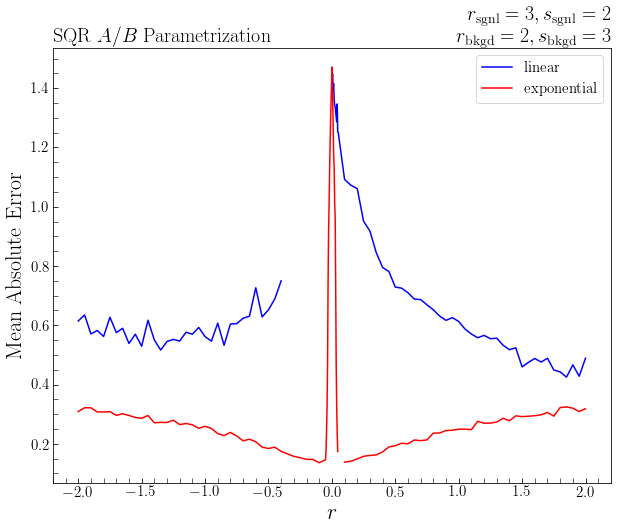

In [8]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(rs, sqr_avgs, c='blue', label='linear')
plt.plot(rs, exp_avgs, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.2)

plt.title(r"$r_{\rm{sgnl}}="+str(3)+r", s_{\rm{sgnl}}="+str(2)+ r"$" + 
          "\n" + r"$r_{\rm{bkgd}}="+str(2)+r", s_{\rm{bkgd}}=" + str(3) + r"$",
          loc="right",
          fontsize=20);
#plt.title(r"$r_{\rm{sgnl}}="+str(6)+r", r_{\rm{bkgd}}="+str(6)+ r"$",
#          loc="right",
#          fontsize=20);
#plt.title(r"$\mu_{\rm{sgnl}}="+str(0.2)+r", \mu_{\rm{bkgd}}="+str(-0.2)+r"$",
#          loc="right",
#          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/sqr_ab_betas_2.png'.format(num), 
            dpi=1200, 
            bbox_inches='tight')

## Gammas

In [9]:
num = 4

sqr_avgs = np.load('models/univariate/sqr_ab_param/set_4/lin_gammas_2.npy')
exp_avgs = np.load('models/univariate/sqr_ab_param/set_4/exp_gammas_2.npy')

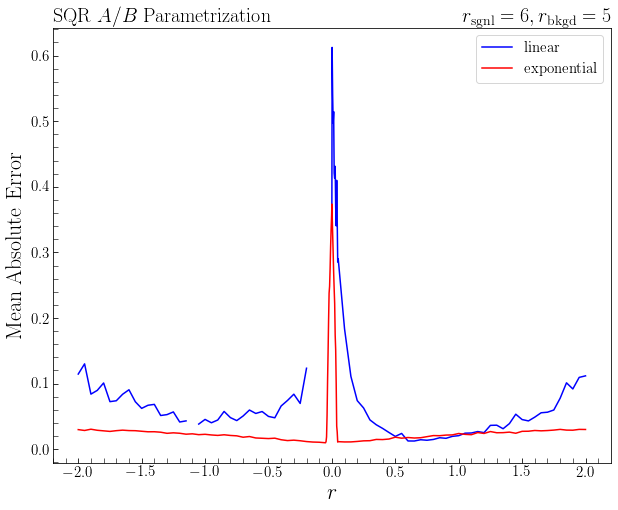

In [10]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(rs, sqr_avgs, c='blue', label='linear')
plt.plot(rs, exp_avgs, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.2)

#plt.title(r"$r_{\rm{sgnl}}="+str(3)+r", s_{\rm{sgnl}}="+str(2)+ r"$" + 
#          "\n" + r"$r_{\rm{bkgd}}="+str(2)+r", s_{\rm{bkgd}}=" + str(3) + r"$",
#          loc="right",
#          fontsize=20);
plt.title(r"$r_{\rm{sgnl}}="+str(6)+r", r_{\rm{bkgd}}="+str(5)+ r"$",
          loc="right",
          fontsize=20);
#plt.title(r"$\mu_{\rm{sgnl}}="+str(0.2)+r", \mu_{\rm{bkgd}}="+str(-0.2)+r"$",
#          loc="right",
#          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/sqr_ab_gammas_2.png'.format(num), 
            dpi=1200, 
            bbox_inches='tight')

## Shifting Gaussians

In [13]:
num = 5
m = 0.2

sqr_avgs = np.load('models/univariate/sqr_ab_param/set_{}/lin_shift.npy'.format(num))
exp_avgs = np.load('models/univariate/sqr_ab_param/set_{}/exp_shift.npy'.format(num))

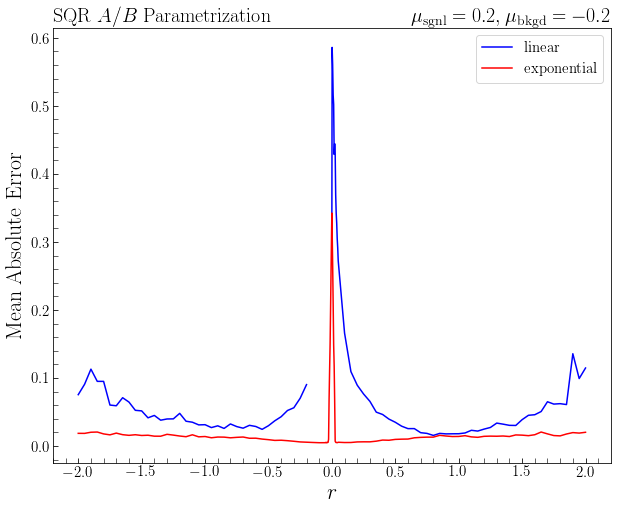

In [14]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(rs, sqr_avgs, c='blue', label='linear')
plt.plot(rs, exp_avgs, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.2)

#plt.title(r"$r_{\rm{sgnl}}="+str(3)+r", s_{\rm{sgnl}}="+str(2)+ r"$" + 
#          "\n" + r"$r_{\rm{bkgd}}="+str(2)+r", s_{\rm{bkgd}}=" + str(3) + r"$",
#          loc="right",
#          fontsize=20);
#plt.title(r"$r_{\rm{sgnl}}="+str(6)+r", r_{\rm{bkgd}}="+str(5)+ r"$",
#          loc="right",
#          fontsize=20);
plt.title(r"$\mu_{\rm{sgnl}}="+str(m)+r", \mu_{\rm{bkgd}}="+str(-m)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/sqr_ab_shift_{}.png'.format(m), 
            dpi=1200, 
            bbox_inches='tight')

In [15]:
num = 6
m = 0.3

sqr_avgs = np.load('models/univariate/sqr_ab_param/set_{}/lin_shift.npy'.format(num))
exp_avgs = np.load('models/univariate/sqr_ab_param/set_{}/exp_shift.npy'.format(num))

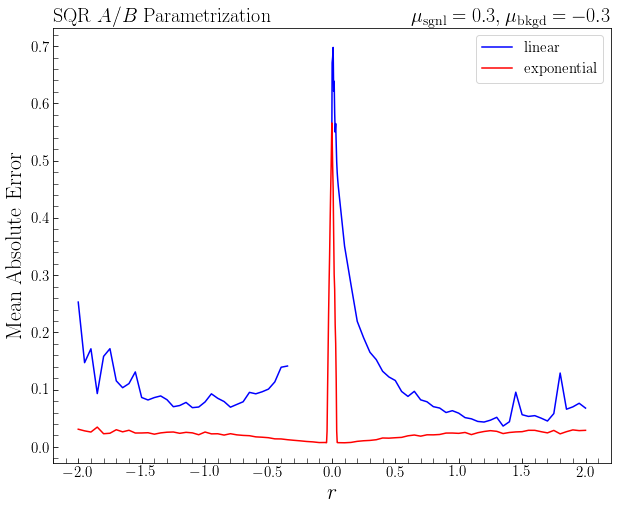

In [16]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(rs, sqr_avgs, c='blue', label='linear')
plt.plot(rs, exp_avgs, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.2)

#plt.title(r"$r_{\rm{sgnl}}="+str(3)+r", s_{\rm{sgnl}}="+str(2)+ r"$" + 
#          "\n" + r"$r_{\rm{bkgd}}="+str(2)+r", s_{\rm{bkgd}}=" + str(3) + r"$",
#          loc="right",
#          fontsize=20);
#plt.title(r"$r_{\rm{sgnl}}="+str(6)+r", r_{\rm{bkgd}}="+str(5)+ r"$",
#          loc="right",
#          fontsize=20);
plt.title(r"$\mu_{\rm{sgnl}}="+str(m)+r", \mu_{\rm{bkgd}}="+str(-m)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/sqr_ab_shift_{}.png'.format(m), 
            dpi=1200, 
            bbox_inches='tight')

In [17]:
num = 7
m = 0.4

sqr_avgs = np.load('models/univariate/sqr_ab_param/set_{}/lin_shift.npy'.format(num))
exp_avgs = np.load('models/univariate/sqr_ab_param/set_{}/exp_shift.npy'.format(num))

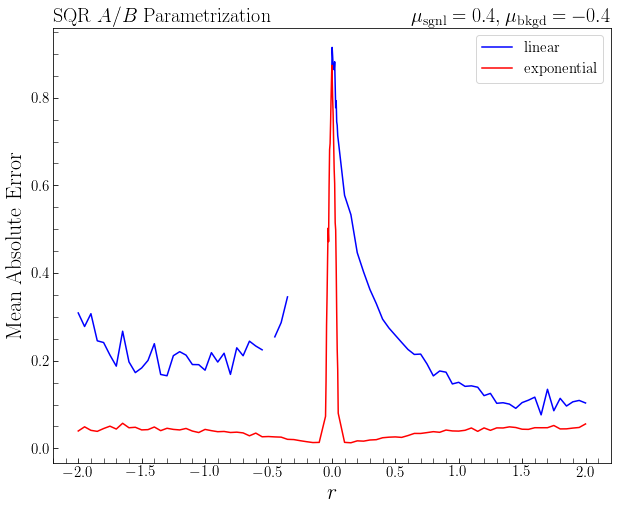

In [18]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(rs, sqr_avgs, c='blue', label='linear')
plt.plot(rs, exp_avgs, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.2)

#plt.title(r"$r_{\rm{sgnl}}="+str(3)+r", s_{\rm{sgnl}}="+str(2)+ r"$" + 
#          "\n" + r"$r_{\rm{bkgd}}="+str(2)+r", s_{\rm{bkgd}}=" + str(3) + r"$",
#          loc="right",
#          fontsize=20);
#plt.title(r"$r_{\rm{sgnl}}="+str(6)+r", r_{\rm{bkgd}}="+str(5)+ r"$",
#          loc="right",
#          fontsize=20);
plt.title(r"$\mu_{\rm{sgnl}}="+str(m)+r", \mu_{\rm{bkgd}}="+str(-m)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/sqr_ab_shift_{}.png'.format(m), 
            dpi=1200, 
            bbox_inches='tight')

In [19]:
num = 8
m = 0.5

sqr_avgs = np.load('models/univariate/sqr_ab_param/set_{}/lin_shift.npy'.format(num))
exp_avgs = np.load('models/univariate/sqr_ab_param/set_{}/exp_shift.npy'.format(num))

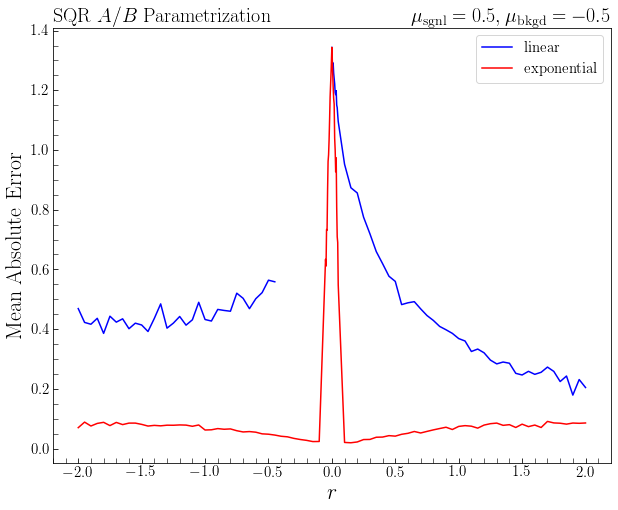

In [20]:
fig, ax = plt.subplots(figsize = (10, 8))

plt.plot(rs, sqr_avgs, c='blue', label='linear')
plt.plot(rs, exp_avgs, c='red', label='exponential')
plt.legend()

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.2)

#plt.title(r"$r_{\rm{sgnl}}="+str(3)+r", s_{\rm{sgnl}}="+str(2)+ r"$" + 
#          "\n" + r"$r_{\rm{bkgd}}="+str(2)+r", s_{\rm{bkgd}}=" + str(3) + r"$",
#          loc="right",
#          fontsize=20);
#plt.title(r"$r_{\rm{sgnl}}="+str(6)+r", r_{\rm{bkgd}}="+str(5)+ r"$",
#          loc="right",
#          fontsize=20);
plt.title(r"$\mu_{\rm{sgnl}}="+str(m)+r", \mu_{\rm{bkgd}}="+str(-m)+r"$",
          loc="right",
          fontsize=20);
plt.title(r"SQR $A/B$ Parametrization",loc="left",fontsize=20);
plt.savefig('plots/sqr_ab_shift_{}.png'.format(m), 
            dpi=1200, 
            bbox_inches='tight')